<a href="https://colab.research.google.com/github/petiesmo/Structural-Projects/blob/main/Hex_Frame_mm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Structural Stiffness Analysis
##Hexagonal Cell 
---
Assumptions:
- Homogeneous, Isotropic material
- Linear Elastic loading
- Small displacements
- 2D planar motion
- Rigid connections at intersections


##System Calls & Imports 

In [1]:
!pip install anastruct

In [2]:
import anastruct as ast
from anastruct import SystemElements
from anastruct import Vertex
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint

##Model Input Parameters

In [3]:
# Unit scaling (N-mm-s)
N = 1
uN = 10**-6 * N
mm = 1
m = 10**3 *mm
um = 10**-3 * mm
nm = 10**-6 * mm
Pa = 10**-6 * N / mm**2
MPa = 1 * N / mm**2
GPa = 10**3 * MPa
deg = np.pi / 180  #Radians

In [4]:
#Geometry
leg = 60 * um
base = 60 * um
phi = 120 * deg

# Beam Cross-Section (Rectangular)
t_xs = 3.5 * um   # Leg thickness, Beam 'height'
d_xs = 25 * um       # Zaxis depth, Beam 'width'
A_xs = t_xs * d_xs
I_xs = d_xs * t_xs**3 / 12

# Material Properties
E_y = 169 * GPa
p = 0.29
Sy = 7 * GPa

##Functions

In [5]:
def Vector(L,theta):
  ''' Given a (Length,Angle) vector input ,
  Returns an (x,y) coordinate Vertex object.'''
  return Vertex(L*np.cos(theta), L*np.sin(theta))

In [6]:
def struct_solve(EA_, EI_, load = 100*uN, show=True):
  ss = SystemElements(EA=EA_, EI=EI_)
  p0 = Vertex(leg,0)
  p1 = p0 + Vector(leg,phi)
  p2 = p1 + Vector(leg,phi/2)
  p3 = p2 + Vector(base/2,0)
  p4 = p3 + Vector(base/2,0)
  p5 = p0 + Vector(base,0)
  p6 = p5 + Vector(leg,phi/2)

  ss.add_element(location=[p0,p1])
  ss.add_element(location=[p1,p2])
  ss.add_element(location=[p2,p3])
  ss.add_element(location=[p3,p4])
  ss.add_element(location=[p4,p6])
  ss.add_element(location=[p5,p6])
  ss.add_element(location=[p0,p5])

  ss.add_support_fixed(1)
  ss.add_support_fixed(7)
  ss.q_load(q=-load/leg, element_id=3, direction='y')
  ss.q_load(q=-load/leg, element_id=4, direction='y')
  if show: ss.show_structure(offset = (0,0))
  ss.solve()

  #Report nodal results information: (id, Fx, Fy, Ty, ux, uy, phi_y)
  res = ss.get_node_results_system()    
  disp_raw = dict([(d[0],d[4:]) for d in res])
  react_raw = dict([(r[0],r[1:4]) for r in res])
  if show: ss.show_displacement(factor=100)

  #Convert results to nm and degrees
  disp = {k:[np.round(x/nm,3), np.round(y/nm,3), np.round(th*180/np.pi,3)] for k,(x,y,th) in disp_raw.items()}
  disp['units'] = ['nm', 'nm', 'deg']
  react = {k:[np.round(x/uN,3), np.round(y/uN,3), np.round(th/uN/nm,3)] for k,(x,y,th) in react_raw.items()}
  react['units'] = ['uN', 'uN', 'uN*nm']
  #pprint(disp_raw)
  #pprint(react_raw)
  #print('nm, nm, deg')
  loaduN = np.round(load/uN)
  return {loaduN: {'load':f'{loaduN} uN', 'react':react, 'disp':disp}}

##Results

###At Client's stated load: 100 uN

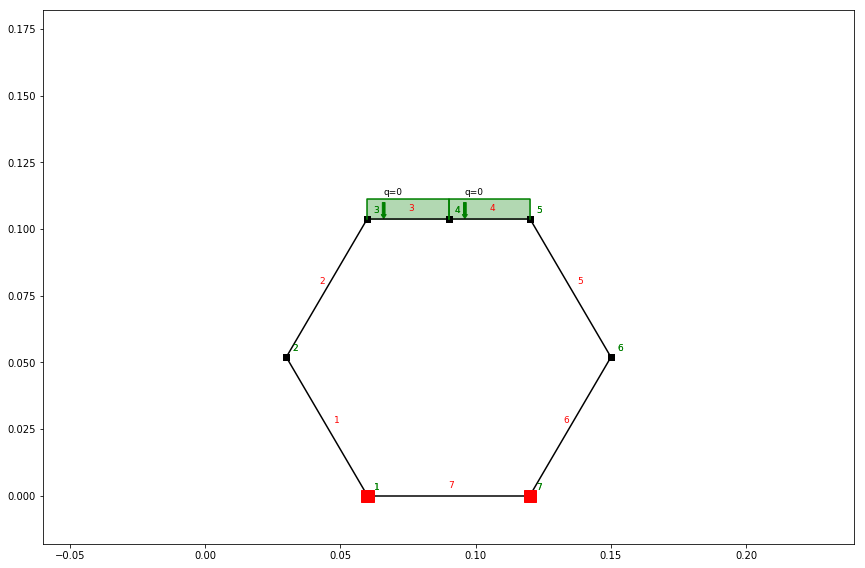

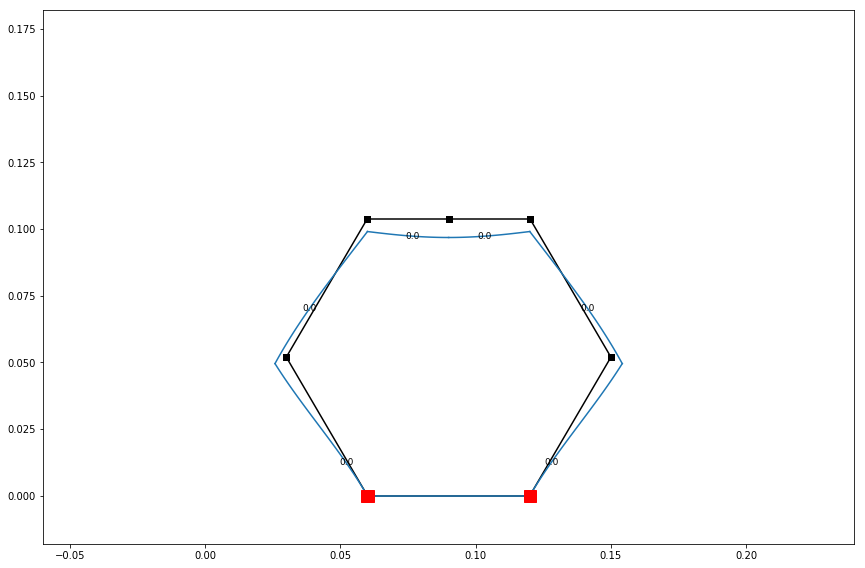

{100.0: {'disp': {1: [-0.0, 0.0, -0.0],
                  2: [41.858, 24.348, -0.018],
                  3: [-0.018, 48.75, 0.071],
                  4: [0.0, 71.111, -0.0],
                  5: [0.018, 48.75, -0.071],
                  6: [-41.858, 24.348, 0.018],
                  7: [-0.0, 0.0, -0.0],
                  'units': ['nm', 'nm', 'deg']},
         'load': '100.0 uN',
         'react': {1: [-9.018, -50.0, 1062300.614],
                   2: [0.0, -0.0, -0.0],
                   3: [-0.0, 0.0, -0.0],
                   4: [0.0, -0.0, -0.0],
                   5: [0.0, 0.0, -0.0],
                   6: [-0.0, 0.0, -0.0],
                   7: [9.018, -50.0, -1062300.473],
                   'units': ['uN', 'uN', 'uN*nm']}}}


In [7]:
load1 = 100 * uN
EA_hex = E_y * A_xs
EI_hex = E_y * I_xs
results = struct_solve(EA_hex, EI_hex, load1, show=True)
pprint(results)

###Check linearity over a range of loads
25uN to 3200uN (by factors of 2)

In [8]:
#@title
EA_hex = E_y * A_xs
EI_hex = E_y * I_xs
loads = [load1*2**i for i in range(-2,5,1)]
res = {}
for load in loads:
  res.update(struct_solve(EA_hex, EI_hex, load, show=False))
pprint(res)

{25.0: {'disp': {1: [-0.0, 0.0, -0.0],
                 2: [10.464, 6.087, -0.004],
                 3: [-0.005, 12.187, 0.018],
                 4: [0.0, 17.778, -0.0],
                 5: [0.005, 12.187, -0.018],
                 6: [-10.464, 6.087, 0.004],
                 7: [-0.0, 0.0, -0.0],
                 'units': ['nm', 'nm', 'deg']},
        'load': '25.0 uN',
        'react': {1: [-2.254, -12.5, 265575.153],
                  2: [0.0, -0.0, -0.0],
                  3: [-0.0, 0.0, -0.0],
                  4: [0.0, -0.0, -0.0],
                  5: [0.0, 0.0, -0.0],
                  6: [-0.0, 0.0, -0.0],
                  7: [2.254, -12.5, -265575.118],
                  'units': ['uN', 'uN', 'uN*nm']}},
 50.0: {'disp': {1: [-0.0, 0.0, -0.0],
                 2: [20.929, 12.174, -0.009],
                 3: [-0.009, 24.375, 0.036],
                 4: [0.0, 35.556, -0.0],
                 5: [0.009, 24.375, -0.036],
                 6: [-20.929, 12.174, 0.009],
             

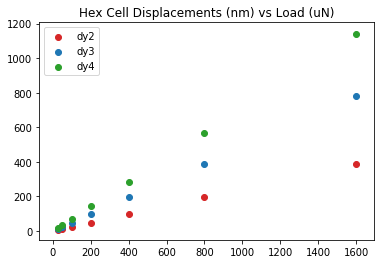

In [9]:
#@title
loads = sorted(res.keys())
dy2 = [res[load]['disp'][2][1] for load in loads]
dy3 = [res[load]['disp'][3][1] for load in loads]
dy4 = [res[load]['disp'][4][1] for load in loads]
M1 = [res[load]['react'][1][2] for load in loads]
plt.scatter(loads,dy2,c='tab:red',label='dy2')
plt.scatter(loads,dy3,c='tab:blue',label='dy3')
plt.scatter(loads,dy4,c='tab:green',label='dy4')
plt.legend()
plt.title('Hex Cell Displacements (nm) vs Load (uN)')
plt.show()


In [10]:
#@title
kstiff = [f/d for f,d in zip(loads,dy4)]
#print(kstiff)
abc = np.round(np.mean(kstiff),4)
print(f'Avg Stiffness: {abc} uN/nm at Node4 (midspan of top)')
print(f'Conversely: {np.round(1/abc,5)} nm/uN at Node4')

Avg Stiffness: 1.4062 uN/nm at Node4 (midspan of top)
Conversely: 0.71114 nm/uN at Node4
